<html>
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>入門機械学習による異常検出</h1>
	<p>
		井出　剛著の「入門機械学習による異常検出」(以降、井出本と記す)の例題をSageを使ってお復習いします。
	</p>
</html>

<html>
	<h2>3章　非正規データからの異常検知</h2>
	<p>
		井出本の基本は、データに対するモデルを使って負の対数尤度を求め、それを異常検出関数として使うことです。
	</p>
</html>

<html>
	<h2>分布が左右対称でない場合</h2>
	<p>
		Davisの体重（weight）のヒストグラムを見ると、分布が左右対称ではないことに気づきます。
		井出本では、ガンマ分布を使ってこの非対称な分布の異常度を検出しています。
	</p>
	<h3>準備</h3>
	<p>
		いつものように必要なパッケージを読込ます。
	</p>
</html>

In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/sage_table_form.css">

In [2]:
# RとPandasのデータフレームを相互に変換する関数を読み込む
# Rの必要なライブラリ
r('library(ggplot2)')
r('library(jsonlite)')

# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
load('script/sage_util.py')
# Rユーティリティ
load('script/RUtil.py')

In [3]:
# 2.2 carパッケージのDavisを使って例題を試す
r('library(car)')
r('library(MASS)') 

 [1] "MASS"      "car"       "jsonlite"  "ggplot2"   "stats"     "graphics"  "grDevices" "utils"    
 [9] "datasets"  "methods"   "base"     

<html>
	<h3>体重のヒストグラム</h3>
	<p>
		Davisの体重のヒストグラムを再度プロットしてみます。
		1個だけ160のところにありますが、2章ではこれが体重と身長を入れ間違えたものと結論づけています。
	</p>
</html>

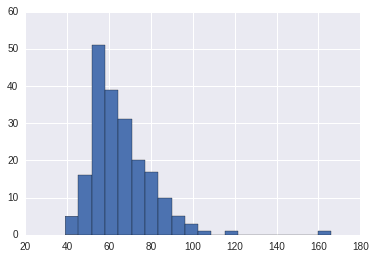

In [4]:
# Rのデータをpandaのデータフレームに変換する
davis = RDf2PandaDf("Davis")
# weightの分布をみる
# 1個だけ、160以上の値を示している
davis.weight.hist(bins=20)
plt.show()

<html>
	<h3>ガンマ分布の対数尤度</h3>
	<p>
		2章と同様にガンマ分布の対数尤度を求めてみます。
	</p>
	<p>
		井出本では、ガンマ分布を以下の様に定義しています。
$$
	\mathcal{G} (x | k, s) = \frac{1}{s \Gamma(k)}(\frac{x}{s})^{k-1} exp(- \frac{x}{s})	
$$		
	</p>
	<p>
		これから対数尤度Lは、以下の様になります。
$$
	L(k, s | \mathcal{D}) = \sum_{n=1}^N \left [ -ln\{s \Gamma(k) \} + (k-1) ln\frac{x^{(n)}}{s} - \frac{x^{(n)}}{s} \right ]
$$
	</p>
	<p>
		この式をパラメータkとsで微分し、０と等しいとします。
	</p>
	<p>
$-ln\{s \Gamma(k) \}$が$-ln(s) - ln(\Gamma(k))$となりますから、sの偏微分は以下の様になります。

$$
\begin{eqnarray}
	\frac{\partial L}{\partial s} & = & \sum_{n=1}^N \left [ -\frac{1}{s} + (k-1)\frac{\partial}{\partial s} ln \frac{x^{(n)}}{s} + \frac{x^{(n)}}{s^2} \right ] \\
	& = & \sum_{n=1}^N \left [ -\frac{1}{s} - \frac{(k-1)}{s} + \frac{x^{(n)}}{s^2} \right ] \\
	& = & \sum_{n=1}^N \left [ -\frac{k}{s} + \frac{x^{(n)}}{s^2} \right ] 
\end{eqnarray}
$$		
		この式が0となることから、
$$
	\hat{s} = \frac{1}{\hat{k} N} \sum_{n=1}^N x^{(n)} = \frac{\hat{\mu}}{\hat{k}}
$$		
	</p>
	<p>
		同様にkの偏微分は以下の様になります。
$$
	\frac{\partial L}{\partial k} = \sum_{n=1}^N \left [ -\frac{1}{\Gamma(k)}\frac{\partial \Gamma(k)}{\partial k} + ln \frac{x^{(n)}}{s}\right ] 
$$		
		しかし、kがガンマ関数が入っているので、簡単には$\hat{k}$は求まりません。
	</p>
</html>

<html>
	<h3>モーメント法を使ったk, sの推定</h3>
	<p>
		井出本では、最尤推定でk, sを求める代わりにモーメント法を使ってkとsを推定しています。

		1次のモーメントは以下の様に計算されます。$\Gamma(k+1) = k \Gamma(k)$を関係を使っています。(以下の式は未フォロー)
		
$$
	\lt x \gt = \int_0^{\infty} dx \, x \, \mathcal{G}(x | k,s) =  s\frac{\Gamma(k+1)}{\Gamma(k)} \int_0^{\infty} dx \, x \, \mathcal{G}(x | k+1,s) = ks
$$			
		同様に２次のモーメントは、以下の様になります。
		
$$
	\lt x^2 \gt = k(k+1)s^2
$$			
	</p>
	<p>
		これとデータから求められる１次の２次モーメントの関係
		
$$
	\lt x \gt = \frac{1}{N} \sum_{n=1}^N x^{(n)} 
$$	

$$
	\lt x^2 \gt = \frac{1}{N} \sum_{n=1}^N {x^{(n)}}^2
$$	
	</p>
	<p>
		この関係から
$$
	\hat{k}_{mo} = \frac{\hat{\mu}^2}{\hat{\sigma}^2}, \hat{s}_{mo} = \frac{\hat{\sigma}^2}{\hat{\mu}}
$$		
	</p>
</html>

<html>
	<h3>davisの体重を使って計算してみる</h3>
	<p>
		davisのweight(体重）でモーメント法を使ってk, sを求めてみます。
	</p>
</html>


In [5]:
# ガンマ分布の異常検出
N = len(davis.weight)
mu = davis.mean()['weight']
si = davis.std()['weight']*(N-1)/N
kmo = (mu/si)^2
smo = si^2/mu
print kmo, smo

19.1928236809 3.42836474164


<html>
	<h3>Rのfitdistrを使ってガンマ分布を推定</h3>
	<p>
		Rのfitdistrを使ってdavisのweight(体重）のガンマ分布を推定してみます。
		shapeがkの値、rateが1/sの値として返されます。
	</p>
	<p>
		モーメント法とfitdistrの結果は、そこそこ近い結果となっています。
	</p>
</html>


In [6]:
r('ml <- fitdistr(Davis$weight, "gamma")')

     shape         rate   
  22.4854793    0.3417247 
 ( 2.2317648) ( 0.0342978)

In [7]:
kml = r('ml$estimate["shape"]')
sml = 1/r('ml$estimate["rate"]')
print kml
print sml

   shape 
22.48548 
    rate 
2.926333 


<html>
	<h3>scipyのstatsを使ってガンマ分布を推定</h3>
	<p>
		このノートの特徴は、Sageとpythonを使って井出本と同じ結果を求めることにあります。
	</p>
	<p>
		scipyのstatsのgamma.fitを使って、kとsを求めてみます。
		gamma.fitでは、floc=0を指定しないとfitdistrと同じ結果になりません。
	</p>
</html>

In [8]:
# SciPyのstatsを使ってガンマ分布の最尤推定値を求める、floc=0を指定するとfitdistrと同じ結果になる
from scipy import stats
fit_alpha, fit_loc, fit_beta = stats.gamma.fit(np.array(davis.weight), floc=0)
print(fit_alpha, fit_loc, fit_beta)

(22.48530359200564, 0, 2.9263558630978119)


<html>
	<h3>結果の可視化</h3>
	<p>
		Sage6.7からヒストグラムがサポートされました。
	</p>
	<p>
		通常のヒストグラムと正規化（normed=True）したヒストグラムが表示でき、
		他のプロットデータと重ね合わせることができます。
	</p>
</html>

In [9]:
# Pandasのデータフレームからweightを取り出す
weight = list(davis.weight.values)

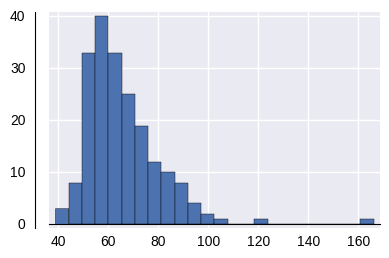

In [10]:
# Sage6.7で導入されたhistogramを使用、binsのデフォルトは10
histogram(weight, figsize=4, bins=24)

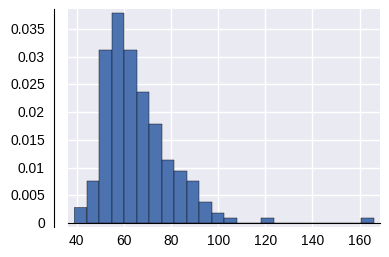

In [11]:
# 正規化したグラフも可能
hg = histogram(weight, figsize=4, bins=24, normed=True)
hg.show()

In [12]:
def _gamma(x, k, s):
    return 1/(s*gamma(k))*(x/s)^(k-1)*exp(-x/s)

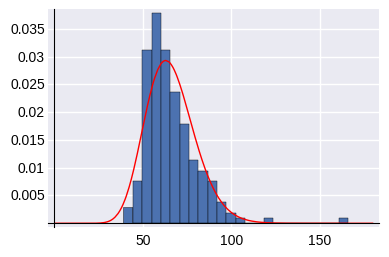

In [13]:
gp = plot(_gamma(x, 22.48548, 2.926333), [x, 0, 180], rgbcolor='red')
(gp+hg).show()

<html>
	<h3>2章の正規分布との重ね合わせ</h3>
	<p>
		以下の様に正規分布関数_gaussを定義して、ヒストグラム、正規分布、ガンマ分布の推定結果を
		重ね合わせてみます。
	</p>
</html>

In [14]:
def _gauss(x, mu, sig2):
    return 1/sqrt(2*pi*sig2)*exp(-1/(2*sig2)*(x - mu)^2)

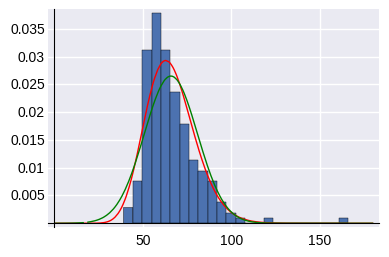

In [15]:
# 正規分布として推定した結果（2章の結果を利用）
sig2 = 226.7
mu = 65.8
ga = plot(_gauss(x, mu, sig2), [x, 0, 180], rgbcolor='green')
(hg+gp+ga).show(figsize=4)

<html>
	<h3>stats.gamma.fitの精度</h3>
	<p>
		最初、flocを指定しないでフィッティングをしたため、fitdistrと結果が異なり
		悩んでいました。しかしfloc=0とすることで、fitdistrと同じ結果が得られることが
		分かり、floc制約をしない場合、どのような推定結果がでるのか調べて見ました。
	</p>
	<p>
		今回、可視化はmatplotを使いました。floc=0の設定をしない方がより良くフィット
		していることが分かります。
	</p>
</html>

4.37071423219 36.4315013948 6.7193811274


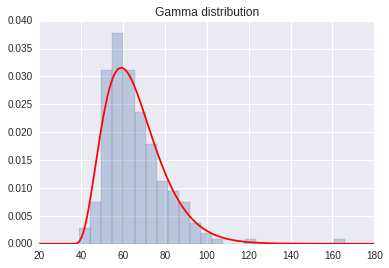

In [16]:
# locも含めた分布のフィッティング結果
samp = np.array(davis.weight)
fit_alpha, fit_loc, fit_beta = stats.gamma.fit(samp)
print fit_alpha, fit_loc, fit_beta
x = np.linspace(20,180,200)

plt.figure()
# fitted distribution
pdf_fitted = stats.gamma.pdf(x, fit_alpha, loc=fit_loc, scale=fit_beta)
plt.title('Gamma distribution')
plt.plot(x,pdf_fitted,'r-')
plt.hist(samp,bins=24, normed=1,alpha=.3)
plt.show()

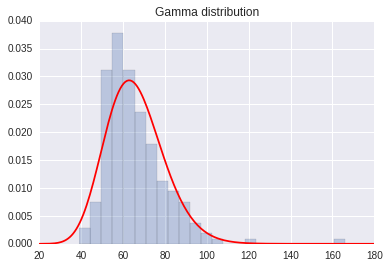

In [17]:
# fitdistrによるフィッティング結果
fit_alpha = 22.48548
fit_loc = 0
fit_beta = 2.926333 
x = np.linspace(20,180,200)

plt.figure()
# fitted distribution
pdf_fitted = stats.gamma.pdf(x, fit_alpha, loc=fit_loc, scale=fit_beta)
plt.title('Gamma distribution')
plt.plot(x,pdf_fitted,'r-')
plt.hist(samp,bins=24, normed=1,alpha=.3)
plt.show()

<html>
	<h2>訓練データに異常データがまざっている場合</h2>
	<p>
		データに異常データが混ざっている場合の例として、以下の様に2種類の正規分布が混ざっている場合に
		ついて考えてみます。
	</p>
</html>

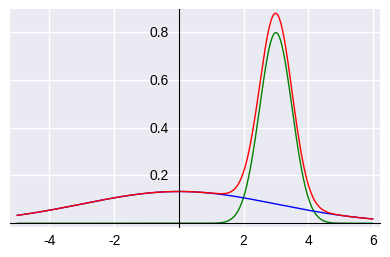

In [18]:
# 訓練データに異常データがまざっている場合（2個の正規分布の混合分布を考える）
x = var('x')
N = 1000
mu0 = 3
mu1 = 0
sig0 = 0.5
sig1 = 3
pi0 = 0.6
pi1 = 0.4
# 分布を表示
g0 = plot(_gauss(x, mu0, sig0^2), [x, -5, 6], rgbcolor='green')
g1 = plot(_gauss(x, mu1, sig1^2), [x, -5, 6], rgbcolor='blue')
g01 = plot(_gauss(x, mu0, sig0^2)+ _gauss(x, mu1, sig1^2), [x, -5, 6], rgbcolor='red')
(g0 + g1 + g01).show(figsize=4)

<html>
	<p>
		分布は以下の様な混合正規分布として表されます。
$$
	p(x) = \pi_0 \mathcal{N}(x | \mu_0, \sigma_0^2) + \pi_1 \mathcal{N}(x | \mu_1, \sigma_1^2) 
$$		
	</p>
	<p>
		パラメータを$ \theta = (\pi_0, \mu_0, \sigma_0^2, \pi_1, \mu_1, \sigma_1^2)$にまとめると、
		対数尤度は、以下の様になります。
$$
	L(\theta, \mathcal{D}) = \sum_{n=1}^N ln \left \{ \pi_0 \mathcal{N}(x | \mu_0, \sigma_0^2) + \pi_1 \mathcal{N}(x | \mu_1, \sigma_1^2) \right \}
$$		
	</p>
	<p>
		これを$\mu_0$で偏微分すると、以下の様になります。
$$
	0 = \frac{\partial L}{\partial \mu_0} = \sum_{n=1}^N \frac{\pi_0 \mathcal{N}(x | \mu_0, \sigma_0^2) }{\pi_0 \mathcal{N}(x | \mu_0, \sigma_0^2) + \pi_1 \mathcal{N}(x | \mu_1, \sigma_1^2)} \frac{(x^{(n)} - \mu_0)}{\sigma_0^2}
$$		
		同様に$\sigma_0^2$で偏微分すると、以下の様になります。
$$
	0 = \frac{\partial L}{\partial \sigma_0^2} = \sum_{n=1}^N \frac{\pi_0 \mathcal{N}(x | \mu_0, \sigma_0^2) }{\pi_0 \mathcal{N}(x | \mu_0, \sigma_0^2) + \pi_1 \mathcal{N}(x | \mu_1, \sigma_1^2)} \frac{ \{-(x^{(n)} - \mu_0)^2 + \sigma_0^2 \}}{2}
$$
		ここで、データが$\pi_i$のどちらの集合に属するかその期待値を帰属度として以下の様に定義します。
$$
	q_i^{(n)} = \frac{\pi_i \mathcal{N}(x | \mu_i, \sigma_i^2) }{\pi_0 \mathcal{N}(x | \mu_0, \sigma_0^2) + \pi_1 \mathcal{N}(x | \mu_1, \sigma_1^2)}
$$		
	</p>
	<p>
		$\mu_i, \sigma_i^2$の推定値は、以下の様に求まります。
$$
	\hat{\mu}_i = \frac{\sum_{n=1}^N q_i^{(n)} x^{(n)}}{\sum_{n'=1}^N q_i^{(n')}}
$$		
$$
	\hat{\sigma}_i^2 = \frac{\sum_{n=1}^N q_i^{(n)} (x^{(n)} - \mu_i)^2}{\sum_{n'=1}^N q_i^{(n')}}
$$
	</p>
	<p>
		また、$\pi_i$は、以下の様になります。
$$
	\hat{\pi}_i = \frac{1}{N} \sum_{n=1}^N q_i^{(n)}
$$		
	</p>
</html>

<html>
	<h3>EMアルゴリズム</h3>
	<p>
		混合正規分布をEMアルゴリズムを使って求めます。
	</p>
	<p>
		EMアルゴリズムでは、以下の手順でパラメータの値を求めます。
		<ol>
			<li>パラメータ$\theta$の初期値をセット</li>
			<li>潜在変数（ここではどの正規分布に属するか）の期待値$q_i^{(n)}$が最大になるようなパラメータを求める</li>
			<li>求まった潜在変数からパラメータの値を再設定する</li>
			<li>値が収束するまで２）に戻る</li>
		</ol>
	</p>
</html>
<html>
	<h3>テストデータの生成</h3>
	<p>
		以下の2つの正規分布をもつテストデータ1000個を生成します。
$$
	(\pi_0, \pi_1) = (0.6, 0.4), (\mu_0, \sigma_0) = (3, 0.5), (\mu_1, \sigma_1) = (0, 3)
$$		
	</p>
</html>

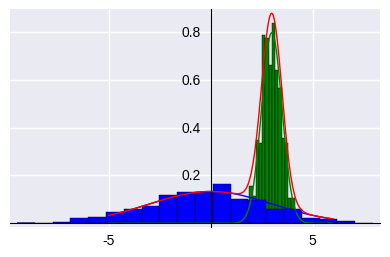

In [19]:
# テストデータの生成
T0 = RealDistribution('gaussian', sig0, seed=1)
d0 = [T0.get_random_element()+mu0 for i in range(pi0*N)]
h0 = histogram(d0, bins=20, normed=True, color='green')

T1 = RealDistribution('gaussian', sig1, seed=1)
d1 = [T1.get_random_element()+mu1 for i in range(pi1*N)]
h1 = histogram(d1, bins=20, normed=True, color='blue')
# プロットして確認
(h0+h1+g0+g1+g01).show(figsize=4)

<html>
	<h3>初期値のセット</h3>
	<p>
		各パラメータの初期値を以下の様に設定します。
$$
	(\pi_0, \pi_1) = (0.5, 0.5), (\mu_0, \sigma_0) = (5, 1.0), (\mu_1, \sigma_1) = (-5, 5.0)
$$		
	</p>
</html>

In [20]:
# データを結合
d = d0 + d1
# pi, sig, muの初期値
pi0 = 0.5
pi1 = 0.5
mu0 = 5.0
mu1 = -5.0
sig0 = 1.0
sig1 = 5.0

<html>
	<h3>EMアルゴリズムの実行</h3>
	<p>
		EMアルゴリズムを10回繰り返します。
	</p>
	<p>
		高々10回の繰り返しで、とても精度良くパラメータが推定されています。
	</p>
</html>

In [21]:
# EMアルゴリズムを10回繰り返す
x = np.array(d)
for i in range(10):
    piN0 = pi0*stats.norm.pdf(x, mu0, sig0); piN1 = pi1*stats.norm.pdf(x, mu1, sig1)
    qn0 = piN0/(piN0 + piN1); qn1 = piN1/(piN0 + piN1)
    pi0 = sum(qn0)/N; pi1 = sum(qn1)/N
    mu0 = sum(qn0*x)/(N*pi0); mu1 = sum(qn1*x)/(N*pi1)
    sig0 = sqrt(sum(qn0*(x - mu0)*(x - mu0))/(N*pi0))
    sig1 = sqrt(sum(qn1*(x - mu1)*(x - mu1))/(N*pi1))

In [22]:
# 結果出力
print pi0, pi1
print mu0, mu1
print sig0, sig1

0.602760455466 0.397239544534
2.98730105891 -0.292164057442
0.512590277559 2.85810740491


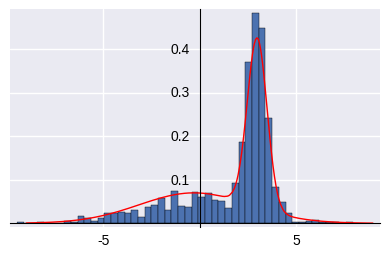

In [23]:
x = var('x')
g01 = plot((_gauss(x, mu0, sig0^2)+ _gauss(x, mu1, sig1^2))/2, [x, -9, 9], rgbcolor='red')
hd = histogram(d, bins=50, normed=True)
(hd + g01).show(figsize=4)

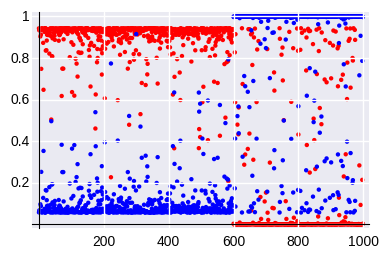

In [24]:
# 帰属度qn0, qn1の分布
q0 = list_plot(list(qn0), rgbcolor='red')
q1 = list_plot(list(qn1))
(q0 + q1).show(figsize=4)

<html>
	<h3>パッケージを使って混合正規分布（GMM）を求める</h3>
	<p>
		最後にScikit-learnの混合正規分布パッケージsklearn.mixtureを使って、
		davisの体重・身長のデータに対して、混合正規分布を求めてみます。
	</p>
	<p>
		GMMは、異常なデータに影響を受けるため、12番目のデータを除いた集合で、
		混合正規分布を求めます。
	</p>
	<p>
		GMMの引数のn_componentsが求める分布の数です。RのMclustを使うとベストな分布数も計算できますが、
		ここでは2として計算します。
	</p>
</html>

In [25]:
# 混合正規分布
# SageでのGMMは、http://www15191ue.sakura.ne.jp:8000/home/pub/57/ を参照してください。
from sklearn import mixture
# 分類器の生成
classifier = mixture.GMM(n_components=2, covariance_type='full')

In [26]:
# GMMを求める
# 12番目のデータを除く（体重と身長を間違えたデータ）
davis_e11 = davis[davis.index != 11]
data = davis_e11[['weight', 'height']]
# 混合正規分布を求める
classifier.fit(data)

GMM(covariance_type='full', init_params='wmc', min_covar=0.001,
  n_components=2, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)

<html>
	<h3>分類結果のプロット</h3>
	<p>
		大切なのは、GMMによる分類ではなく、その結果を可視化して特徴を把握することです。
	</p>
	<p>
		GMMによってデータがどのグループに属するか分類した結果は、predict関数で取得し、
		davis_e11のpredにセットします。
	</p>
	<p>
		次にseabornでpredで色を変えて分布をプロットします。
		たったこれだけで、GMMの結果を確認することができます。
	</p>
</html>

In [28]:
# 分類結果をpredにセット
# davis_e11['pred']= classifier.predict(data)で、Try using .loc[row_indexer,col_indexer] = value insteadのエラー
# 以下のように変更してもエラーがでます。
davis_e11.loc[:, 'pred'] = classifier.predict(data)

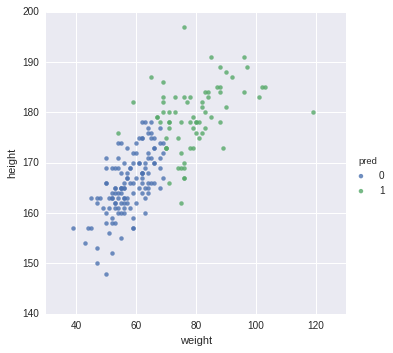

In [29]:
# 分類結果の表示
# 身長（height）と体重（weight）の関係をみる
sns.lmplot('weight', 'height', data=davis_e11, hue='pred', fit_reg=False )
plt.show()

<html>
	<h3>正規分布の形もプロット</h3>
	<p>
		GMMの結果は、$\mu$がmeans_、$\sigma$がcovars_、$\pi$がweights_変数にセットされています。
	</p>
	<p>
		Sageのcontour_plot関数を使って正規分布をプロットしてみます。
	</p>
</html>

In [30]:
# クラス分けされたデータ
cls0 = davis_e11[davis_e11.pred == 0][['weight', 'height']].values
cls1 = davis_e11[davis_e11.pred == 1][['weight', 'height']].values

In [31]:
# 正規分布の推定値
mu0 = vector(classifier.means_[0])
mu1 = vector(classifier.means_[1])
sig0 = matrix(classifier._get_covars()[0])
sig1 = matrix(classifier._get_covars()[1])
show(mu0); show(mu1)
show(sig0); show(sig1)

(57.81913146628779, 166.05287757398474)

(76.24968505812853, 177.23112855273868)

[48.941998128269816 32.602459007078245]
[32.602459007078245  45.28480054167933]

[163.09260007590242  55.50952750063395]
[ 55.50952750063395 55.805714575835765]

In [32]:
# ベクトルのガウス分布を定義
def _gauss(v, mu, sigma):
    d = len(v);
    sigma_inv = sigma.inverse();
    sigma_abs_sqrt = sigma.det().sqrt();
    val = -(v - mu) * sigma_inv * (v - mu).column()/2;
    a = (2*pi)**(-d/2) * sigma_abs_sqrt**-0.5
    return a * e**val[0]; 

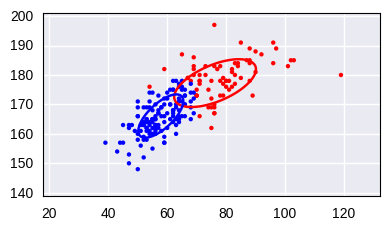

In [33]:
x, y = var('x y')
# データのプロット
pt_plt = Graphics()
for pt in cls1:
    pt_plt += point(pt, rgbcolor='red', zorder=2)
for pt in cls0:
    pt_plt += point(pt, rgbcolor='blue', zorder=2)
# 正規分布を表示
r_cnt_plt = contour_plot(lambda x, y : _gauss(vector([x, y]), mu1, sig1), [x, 20, 130], [y, 140, 200], contours = 1, cmap=['red'], fill=False)
b_cnt_plt = contour_plot(lambda x, y : _gauss(vector([x, y]), mu0, sig0), [x, 20, 130], [y, 140, 200], contours = 1, cmap=['blue'], fill=False)
(pt_plt + r_cnt_plt + b_cnt_plt).show(figsize=4) 

<html>
	<h3>混合正規分布データの異常度</h3>
	<p>
		混合正規分布の異常度は、以下の様になります。
$$
	a(x') = -ln \left \{ \sum_{k=1}^K \hat{\pi}_k \mathcal{N}(x' | \hat{\mu}_k, \hat{\Sigma}_k) \right \}
$$		
	</p>
</html>

In [34]:
#異常度の計算
# pi_nを求める
pi_vec = vector(classifier.weights_); show(pi_vec)
# davis全データに対する事後分布を求める
a = [- log(pi_vec[0]*_gauss(vector(x), mu0, sig0)+pi_vec[0]*_gauss(vector(x), mu1, sig1)).n() for x in davis[['weight', 'height']].values ]

(0.5942959114867427, 0.40570408851325784)

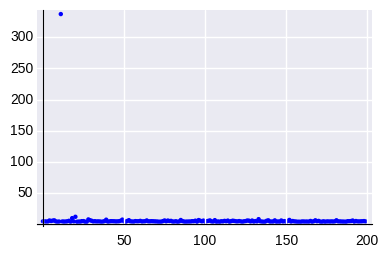

In [35]:
list_plot(a, figsize=4)